supply and demand analysis
calculate changes in oil reserves, including the SPR, weekly and compared to last year
determine if changes are in line with expectations
if not in line with expectations determine if it is do to higher demand, lower production, more exports or a combination

In [1]:
import pandas as pd
import USA_oil_data as oil
import prices
from FRED_oil_data import get_fred_data
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
#sns.set()
sns.set_style("whitegrid")

In [2]:
weekly_stocks = oil.weekly_stocks()
spr = oil.spr_reserves()

In [3]:
merged = pd.merge(weekly_stocks, spr, on='period')
merged.sort_index(inplace=True)

In [4]:
ticks = [x for x in range(0, 1400000, 200000)]

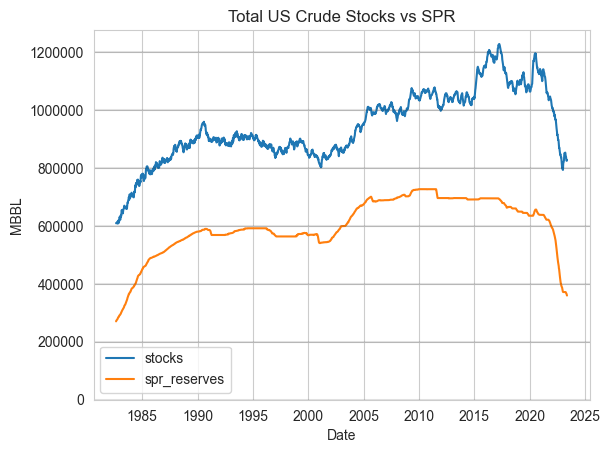

In [5]:
plt.plot(merged)

plt.yticks(ticks)
plt.ticklabel_format(axis='y', style='plain')
for t in ticks:
    plt.axhline(t, color='black', alpha=0.1)

plt.legend(merged.columns)
plt.title("Total US Crude Stocks vs SPR")
plt.xlabel('Date')
plt.ylabel('MBBL')
plt.show()

In [6]:
weekly_stocks = weekly_stocks.to_frame()

In [7]:
weekly_stocks['year'] = weekly_stocks.index.year
weekly_stocks['month'] = weekly_stocks.index.month
weekly_stocks = weekly_stocks[weekly_stocks['year'] > 2015]
monthly_average = weekly_stocks.groupby('month').mean()

In [8]:
grouped = weekly_stocks.groupby('year')

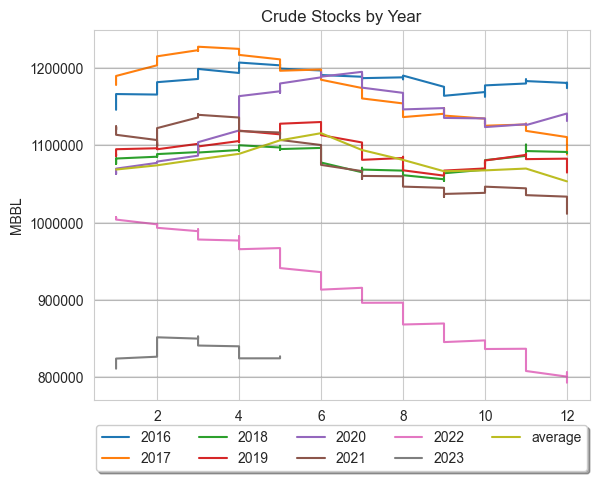

In [9]:
fig, ax = plt.subplots()

for name, group in grouped:
    ax.plot(group['month'], group['stocks'], label=name)
ax.plot(monthly_average.index, monthly_average['stocks'], label='average' )
plt.ticklabel_format(axis='y', style='plain')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
#add horizontal lines
ticks = [x for x in range(800000, 1300000, 100000)]
for t in ticks:
    plt.axhline(t, color='black', alpha=0.1)

plt.title('Crude Stocks by Year')
plt.xlabel('Month')
plt.ylabel('MBBL')
plt.show()

In [10]:
weekly_stocks = oil.weekly_stocks()
weekly_stocks = weekly_stocks.to_frame()

weekly_stocks['year'] = weekly_stocks.index.year
weekly_stocks['month'] = weekly_stocks.index.month

weekly_stocks['diff'] = weekly_stocks['stocks'].diff(-1)
weekly_stocks = weekly_stocks[weekly_stocks['year'] >= 2018]

week_info = weekly_stocks.index.isocalendar()
week_number = week_info['week']

merged_df = pd.merge(week_number, weekly_stocks, left_index=True, right_index=True)

In [11]:
grouped = merged_df.groupby('year')

In [12]:
weeks = grouped['week'].unique()
years = len(grouped['year'].unique())
width = 0.8/years

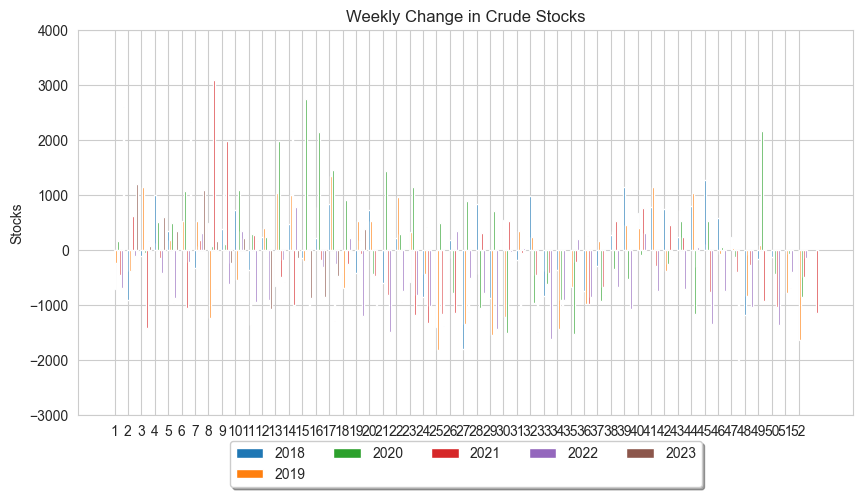

In [16]:
fig, ax = plt.subplots(figsize=(10,5))
i = 0
for name, group in grouped:
    data = group[group['week'] < 53]
    data = group['diff']/7
    positions = group['week']


    ax.bar(positions + i * width, data, width=width, label=name)
    i += 1

plt.xticks(range(1, 53))

plt.ylim(-3000,4000)

ax.set_ylabel('Stocks')
ax.set_xlabel('Week')
#move legend to bottom
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Weekly Change in Crude Stocks')

plt.show()

In [14]:
imports, exports = oil.imports_exports(only_crude=False)

In [66]:
imports_exports = pd.merge(imports, exports, on='period')

imports_exports['year'] = imports_exports.index.year
imports_exports = imports_exports[imports_exports['year'] > 2005]

In [67]:
imports_exports['net'] = imports_exports['imports'] - imports_exports['exports']

Text(0.5, 1.0, 'Imports, Exports and Net Imports')

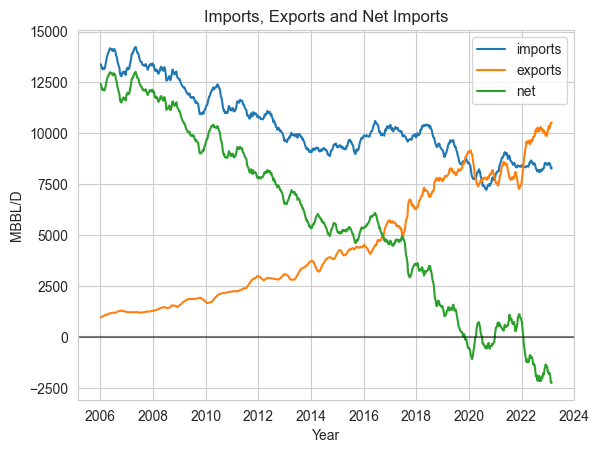

In [68]:
plt.plot(imports_exports[['imports', 'exports', 'net']].rolling(12).mean())
plt.legend(imports_exports[['imports', 'exports', 'net']])
plt.axhline(0, color='black', alpha=0.5)
plt.xlabel('Year')
plt.ylabel('MBBL/D')
plt.title('Imports, Exports and Net Imports')

In [69]:
def convert_to_monthly(data, name='value'):
    data['days_in_month'] = data.index.days_in_month
    data['imports'] = data['imports'] * data['days_in_month']
    data['exports'] = data['exports'] * data['days_in_month']
    data = data[['imports', 'exports']]
    data['net_imports'] = data['imports'] - data['exports']
    data['net'] = data['imports'] - data['exports']
    data = data['net']
    data = data.rename(name)
    return data

In [70]:
#supply data:

#production
production = oil.mbbl_production()

#reserves
reserves = oil.crude_oil_stocks()

#imports
imports = oil.imports()

#demand data:
#product supplied
product_supplied = oil.weekly_product_supplied()
monthly_product_supplied = product_supplied.resample('M').sum()
monthly_product_supplied.index = monthly_product_supplied.index - pd.offsets.MonthBegin(1)
monthly_product_supplied.rename("monthly_product_supplied", inplace=True)

#exprots
exports = oil.exports()

#refinery/blender net inputs
net_refinery = oil.refinery_net_input()
#sales (not updated since March 2022)
#gas_end_users = oil.gasoline_sales_end_user()
#gas_resale = oil.gasoline_sales_resale()


In [71]:
net_imports = imports - exports
net_imports.rename('net_imports', inplace=True)

period
2023-02-01    72754
2023-01-01    85668
2022-12-01    66261
2022-11-01    66028
2022-10-01    64816
              ...  
1920-05-01     6205
1920-04-01     5493
1920-03-01     5611
1920-02-01     4087
1920-01-01     5825
Name: net_imports, Length: 1238, dtype: int64

In [72]:
#merge all data into one dataframe
supply_demand = pd.merge(production, reserves, on='period')
supply_demand = pd.merge(supply_demand, monthly_product_supplied, on='period')
supply_demand = pd.merge(supply_demand, net_imports, on='period')
supply_demand = pd.merge(supply_demand, net_refinery, on='period')



In [73]:
changes = supply_demand.diff(12)
#changes = supply_demand.pct_change(12)

In [74]:
positive_values = changes[changes > 0].sum(axis=1)
negative_values = changes[changes < 0].sum(axis=1)

sd = positive_values + negative_values
sd.rename('sd', inplace=True)

period
2007-05-01        0.0
2007-06-01        0.0
2007-07-01        0.0
2007-08-01        0.0
2007-09-01        0.0
               ...   
2022-10-01    -4765.0
2022-11-01    -4976.0
2022-12-01   -24440.0
2023-01-01    52229.0
2023-02-01    69913.0
Name: sd, Length: 190, dtype: float64

In [75]:
changes = changes[changes.index > '2000-12-01']
changes.index = changes.index.strftime('%Y-%m')

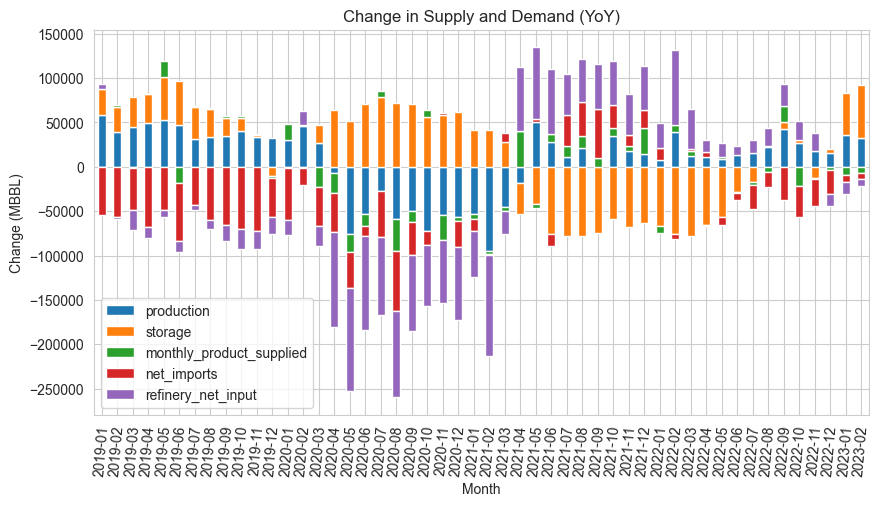

In [76]:
changes = changes[changes.index > '2018-12-01']
fig, ax = plt.subplots(figsize=(10,5))
changes.plot(kind='bar', stacked=True, ax=ax)
plt.title('Change in Supply and Demand (YoY)')
ax.set_xlabel('Month')
ax.set_ylabel('Change (MBBL)')
plt.xticks(rotation=85)
plt.show()

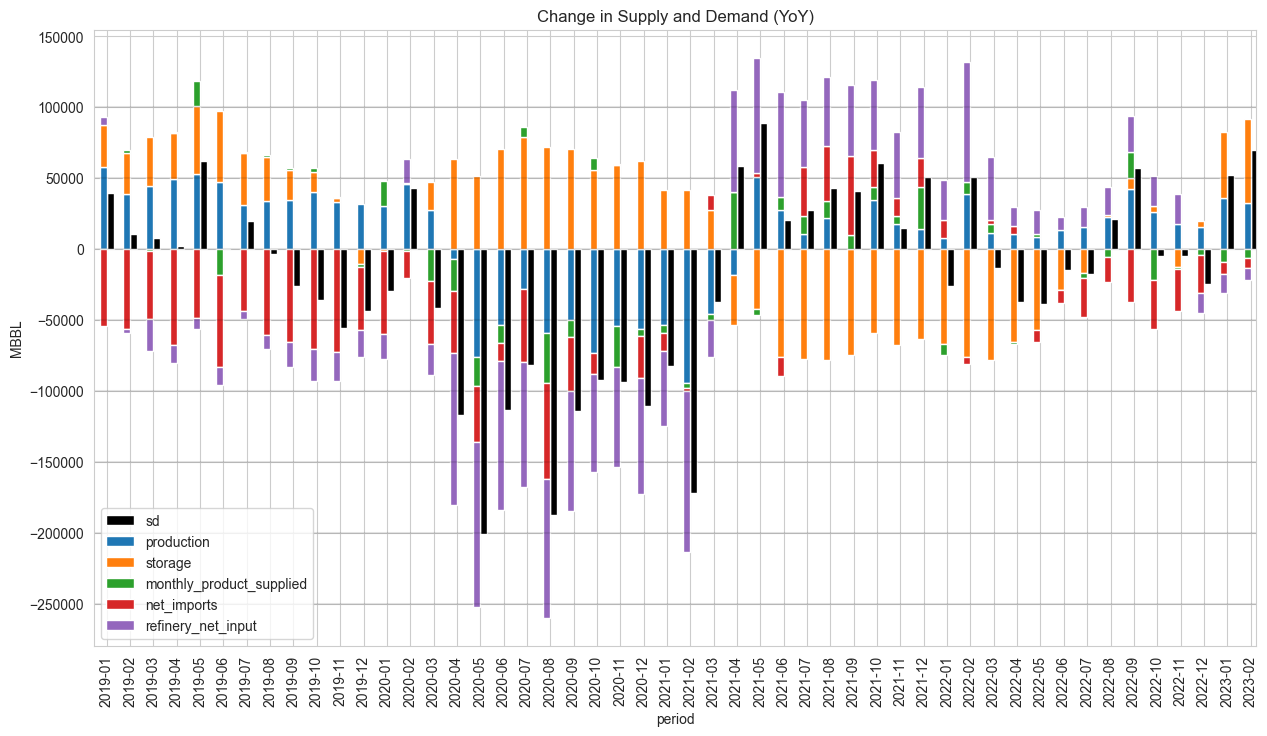

In [77]:
sd_data = sd[sd.index > '2018-12-01']
ax = sd_data.plot.bar(ylabel="MBBL", xlabel="Date", figsize=(15,8),
                 color='black', position=0, width=0.3)

changes.plot.bar(stacked=True, sharex=True, ax=ax, position=1, width=0.3)
for t in range(-250000, 150000, 50000):
    plt.axhline(t, color='black', alpha=0.1)

plt.title('Change in Supply and Demand (YoY)')
ax.legend()

<AxesSubplot:xlabel='period'>

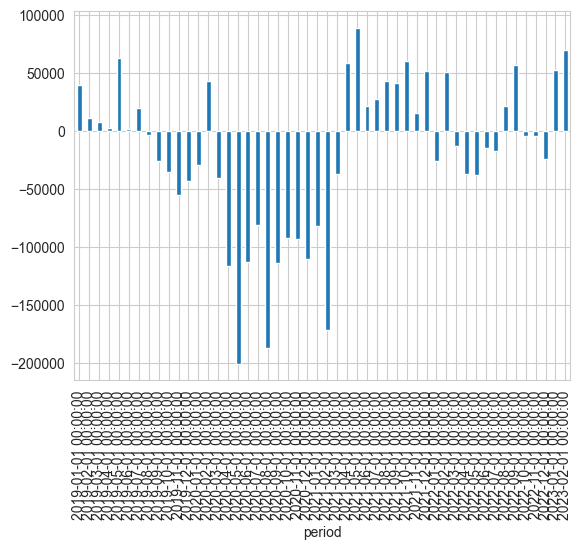

In [78]:
sd_data = sd[sd.index > '2018-12-01']
sd_data.plot(kind='bar')

In [79]:
monthly_net_imports = net_imports
monthly_net_imports = monthly_net_imports[monthly_net_imports.index > '2018-12-01']
monthly_net_imports.index = monthly_net_imports.index.strftime('%Y-%m')

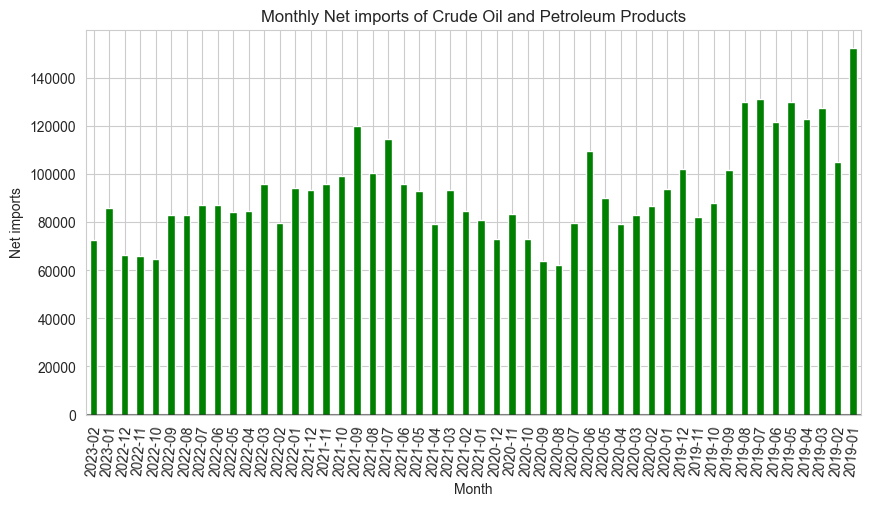

In [80]:
fig, ax = plt.subplots(figsize=(10,5))

monthly_net_imports.plot(kind='bar', ax=ax)
for i, val in enumerate(monthly_net_imports):
    if val > 0:
        ax.patches[i].set_facecolor('green')
    else:
        ax.patches[i].set_facecolor('red')

plt.axhline(0, color='black', alpha=0.5)
ax.set_xlabel('Month')
ax.set_ylabel('Net imports')

plt.xticks(rotation=85)
plt.title('Monthly Net imports of Crude Oil and Petroleum Products')
plt.show()

In [81]:
spr_changes = spr.diff(52)

In [82]:
spr_changes = spr_changes[spr_changes.index > "2018-12-01"]

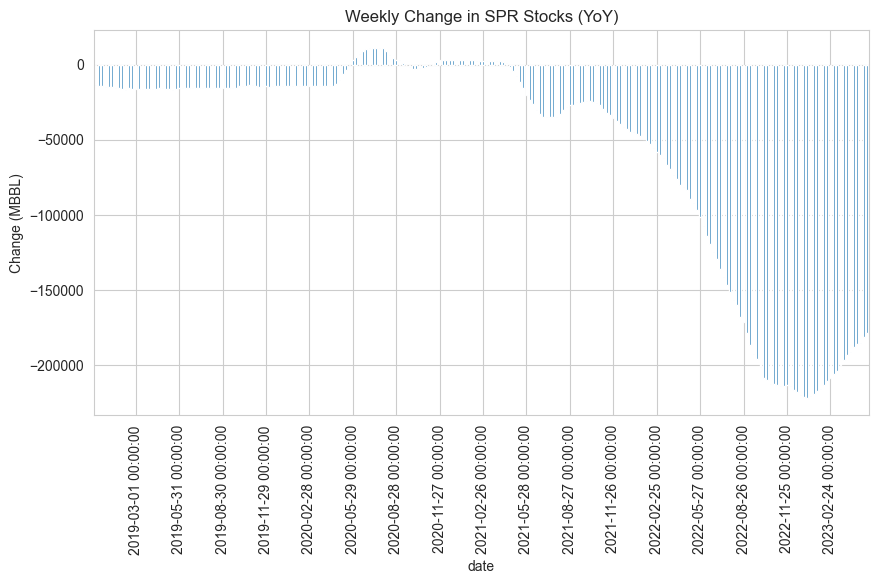

In [83]:
fig, ax = plt.subplots(figsize=(10,5))
spr_changes.plot(kind='bar', ax=ax)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=13))
ax.set_xlabel('date')
ax.set_ylabel('Change (MBBL)')
plt.title('Weekly Change in SPR Stocks (YoY)')
plt.show()

In [84]:
sd = sd.to_frame()

In [85]:
sd.index = pd.to_datetime(sd.index)

In [86]:
sd['year'] = sd.index.year
sd['month'] = sd.index.month

In [87]:
sd['diff'] = sd['sd'].diff(12)
sd = sd[sd.index > '2016-12-01']

In [88]:
grouped = sd.groupby(['year'])

In [89]:
sd

,sd,year,month,diff
period,,,,
2017-01-01,33198.0,2017,1,-70118.0
2017-02-01,-18313.0,2017,2,-139918.0
2017-03-01,47695.0,2017,3,-22404.0
2017-04-01,36521.0,2017,4,-20706.0
2017-05-01,58011.0,2017,5,26120.0
...,...,...,...,...
2022-10-01,-4765.0,2022,10,-65135.0
2022-11-01,-4976.0,2022,11,-20052.0
2022-12-01,-24440.0,2022,12,-75488.0


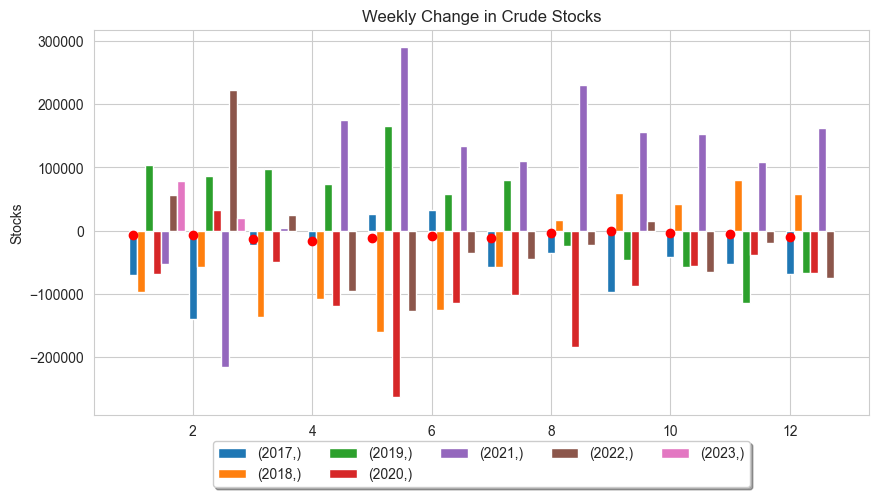

In [90]:
fig, ax = plt.subplots(figsize=(10,5))
i = 0
means = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0}
counts = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0}
for name, group in grouped:
    positions = group['month']
    data = group['diff']
    for row in group.iterrows():
        means[int(row[1]['month'])] += int(row[1]['diff'])
        counts[int(row[1]['month'])] += 1


    ax.bar(positions + i * width, data, width=width, label=name)
    i += 1



ax.set_ylabel('Stocks')
ax.set_xlabel('Week')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Change in SD (YoY) by month')

#calculate means for every month
means_df = pd.DataFrame.from_dict(means, orient='index')
means_df.rename(columns={0:'sums'}, inplace=True)
counts_df = pd.DataFrame.from_dict(counts, orient='index')
means_df['counts'] = counts_df
means_df['mean'] = means_df['sums'] / means_df['counts']

#plot means as red dot
plt.plot(means_df.index, means_df['mean'], 'ro')


plt.show()

In [91]:
forecast = oil.crude_production_forecast(end='2025-01', start='2015-01')

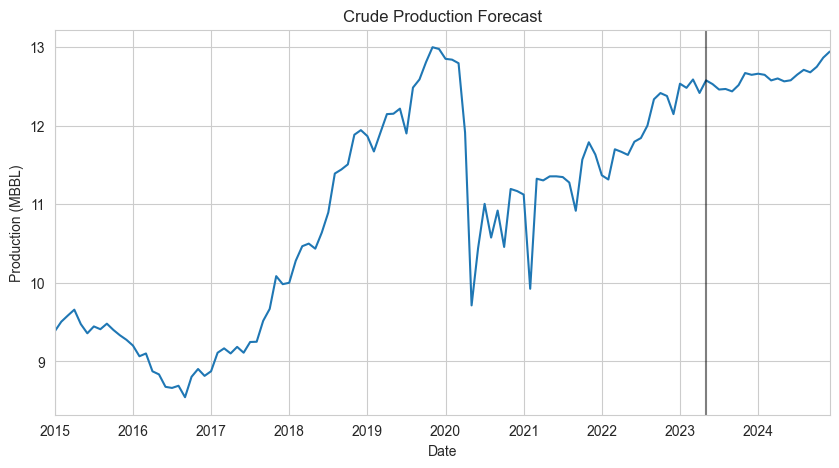

In [92]:
fig, ax = plt.subplots(figsize=(10,5))
forecast.plot(ax=ax)
plt.axvline(pd.to_datetime('today'), color='black', alpha=0.5)
plt.title('Crude Production Forecast')
plt.xlabel('Date')
plt.ylabel('Production (MBBL)')
plt.show()

In [2]:
weekly_stocks = oil.weekly_stocks()
spr = oil.spr_reserves()

In [3]:
weekly_stocks

period
2023-05-12    827210
2023-05-05    824598
2023-04-28    824571
2023-04-21    827856
2023-04-14    833931
               ...  
1982-10-08    613985
1982-10-01    612419
1982-09-24    612419
1982-08-27    608741
1982-08-20    609219
Name: stocks, Length: 2120, dtype: int64

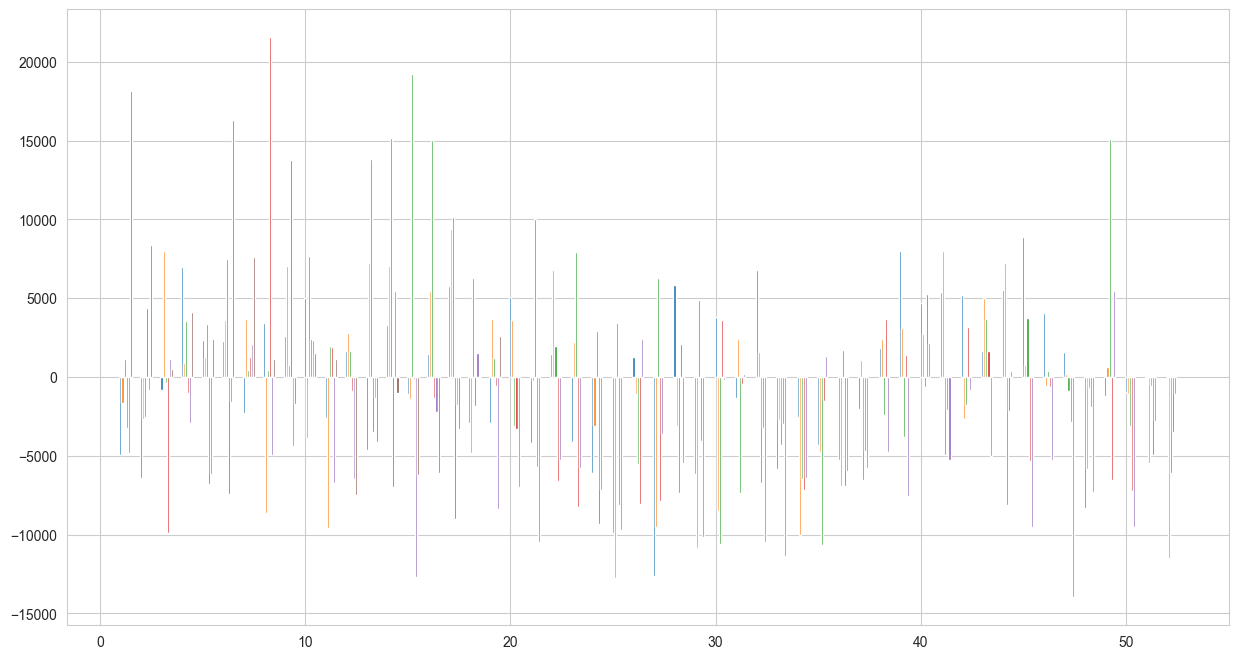

In [59]:
pos = 0
width = 0.1
fig, ax = plt.subplots(figsize=(15,8))
for name, group in grouped:
    position = group['week']
    position = position[position < 53]

    data = group['diff']
    data = data[:52]
    ax.bar(position + pos * width, data, width=width, label=name)
    pos += 1